## Шикунов Николай ИАД-2

In [1]:
import pandas as pd
import numpy as np

**Задание 1**

Проанализировать набор данных и ответить на следующие вопросы:

1) Какой % наблюдений выходит за 5 и 95 перцентиль?

2) Какому закону распределения отвечают данные? На основе чего вы так решили?

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

Описание данных:

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

In [2]:
from scipy.stats import shapiro
from statsmodels.api import qqplot
from scipy.stats import t, norm, expon, kstest, gamma, exponweib, exponpow, ks_2samp, poisson, chisquare, ks_2samp, boxcox
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

import matplotlib.pyplot as plt
import bootstrapped

In [3]:
data = pd.read_csv('test_1_1.csv', sep=';', index_col=0).metrics

Функция распределения нашей величины

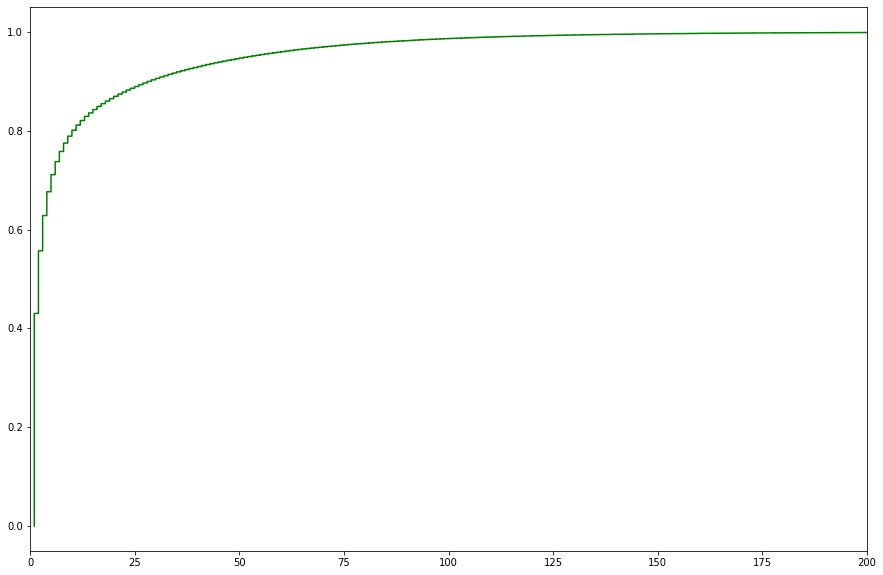

In [4]:
plt.figure(figsize=(15, 10))
x = np.sort(data)
y = np.arange(1, len(x) + 1) / len(x)
plt.title('')
plt.plot(x, y, drawstyle='steps', color='g')
plt.xlim([0, 200])
plt.show()

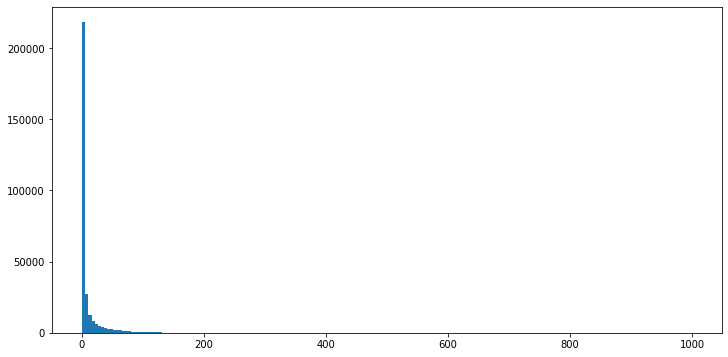

In [5]:
plt.figure(figsize=(12, 6))
plt.hist(data, bins=200)
plt.show()

За 5% перцентиль выходит 57% данных

In [7]:
round(len(data[data > np.percentile(data, 5)]) / len(data), 3)

0.57

За 95% перцентиль выходит 5% данных

In [8]:
round(len(data[data > np.percentile(data, 95)]) / len(data), 3)

0.05

In [9]:
gam_dist = gamma.fit(data)

In [10]:
gam_dist

(0.18623934669047654, 0.9999999999999998, 1.543129709882804)

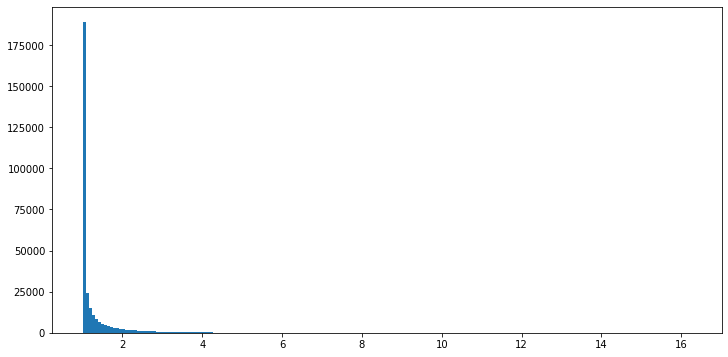

In [11]:
plt.figure(figsize=(12, 6))
plt.hist(gamma.rvs(0.18623934669047654, 0.9999999999999998, 1.543129709882804, size=len(data)), bins=200)
plt.show()

Видно, что наши данные очень похожи на гамма/экспоненциальное распределение. Но проблема в том, что наша величина дискретная. Значит, КС тест использовать нельяз. Получается, что метрика распределена по закону Пуассона

**Задание 2**

Определить, можно сравнить две представленные выборки t критерием Стьюдента? 

Если нельзя сравнивать t-критерием, то что будем использовать и почему?

Ответ аргументировать и описать 

[Ссылка на данные](https://drive.google.com/file/d/1blvC6TEBWghhVMexjOdoGEjzhZZh3wSy/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

*Вместе с ответом на задание приложить код*

In [12]:
from scipy.stats import levene, mannwhitneyu, kstest

In [13]:
data = pd.read_csv('test_1_2.csv', sep=';', index_col=0)

In [14]:
a = data[data.variant == 'A'].metrics
b = data[data.variant == 'B'].metrics

In [15]:
len(a), len(b)

(92686, 91518)

In [16]:
np.mean(a), np.mean(b)

(10.099561961892842, 10.33313665071352)

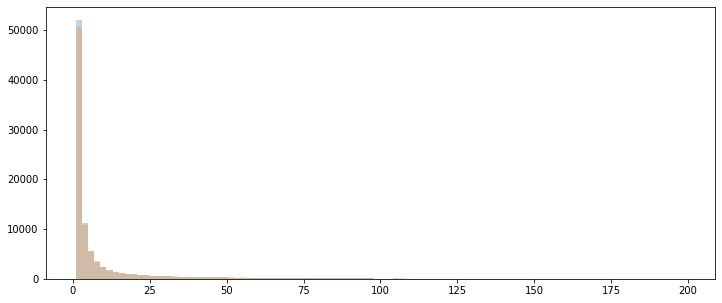

In [17]:
plt.figure(figsize=(12, 5))
plt.hist(a[a < 200], bins=100, alpha=0.3)
plt.hist(b[b < 200], bins=100, alpha=0.3)
plt.show()

Нельзя использовать критерий стюдента, потому что величины дискретные и распределены не нормально

Также, нельзя использовать критерий Манна-Уитни, потому что в данных очень много повторяющихся значений

Воспользуемся непараметрическим бутстрапом

Будем считать разницу средних: $mean(A) - mean(B)$

Гипотеза H0 - группы из одного распределения.
Гипотеза H1 - группы из разных распределений.
Уровень значимости 0.05

In [18]:
bootstrap_diff = []
for n in range(10000):
    sample_a = np.random.choice(a, size=len(a))
    sample_b = np.random.choice(b, size=len(a))
    diff = sample_a.mean() - sample_b.mean()
    bootstrap_diff.append(diff)

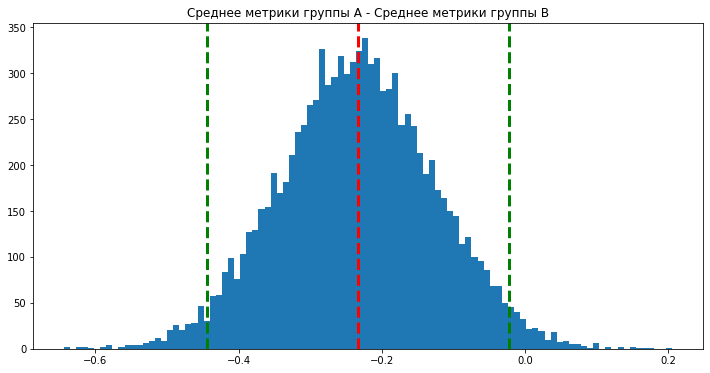

In [19]:
plt.figure(figsize=(12, 6))
plt.hist(bootstrap_diff, bins=100)
plt.title('Среднее метрики группы A - Среднее метрики группы B')
plt.axvline(x=np.mean(bootstrap_diff), linewidth=3, color='r',linestyle='--')
plt.axvline(x=np.percentile(bootstrap_diff, 2.5), linewidth=3, color='g',linestyle='--')
plt.axvline(x=np.percentile(bootstrap_diff, 97.5), linewidth=3, color='g',linestyle='--')
plt.show()

In [20]:
print(f"Доверительный интервал с уровнем доверия 0.95: {np.percentile(bootstrap_diff, 2.5)} - {np.percentile(bootstrap_diff, 97.5)}")

Доверительный интервал с уровнем доверия 0.95: -0.4441638974602422 - -0.022995651986277607


In [21]:
def boot_pvalue(boot_arr):
    boot_arr = np.array(boot_arr)
    neg = sum(boot_arr <=0)
    pos = sum(boot_arr >= 0)
    
    return min(neg, pos) * 2 / len(boot_arr)

In [22]:
boot_pvalue(bootstrap_diff)

0.029

p_value = 0.0284

Отвергаем нулевую гипотезу с уровнем значимости 0.05

Значит, разница статистически значима, метрика в группе B больше метрики в группе A

Попробуем то же самое с помощью библиотеки bootstrapped

In [23]:
bs.bootstrap_ab(a.values, b.values, bs_stats.mean, bs_compare.percent_change)

-2.260443239222517    (-4.276688246311674, -0.25043530869498554)

**Задание 3**

Дано две выборки по А/Б тесту.

Две выборки несбалансированные - кол-во пользователей в каждой группе разные.

Метрика, которую меряем в эксперименте (и которую используем для определения группы, которая лучше себя показала) - кол-во просмотренных страниц на пользователя 

Как вы будете принимать решение, какая группа лучше А или Б, и какие статистические методы (критерии) вы будете использовать, какие преобразования к данным применять? P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

[Ссылка на данные](https://drive.google.com/file/d/1_g7Dw7-8QzTS47D6GNKMb0FzqMAWBDba/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

In [24]:
data = pd.read_csv('hw2_test_1_3.csv', sep=';', index_col=0)

In [25]:
a = data[data.variant == 'A'].metrics
d = data[data.variant == 'D'].metrics

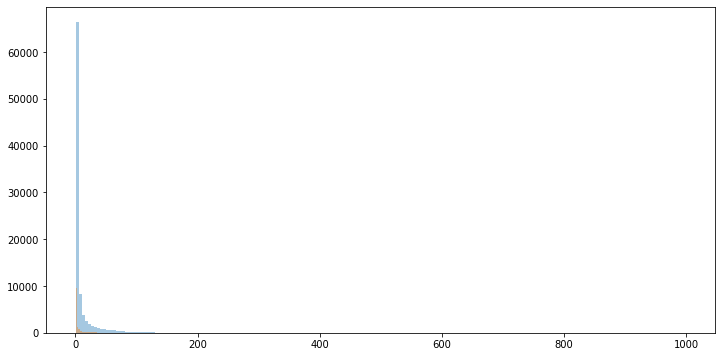

In [26]:
plt.figure(figsize=(12, 6))
plt.hist(a, bins=200, alpha=0.4)
plt.hist(d, bins=200, alpha=0.4)
plt.show()

In [27]:
len(a), len(d)

(92686, 15413)

In [28]:
a.mean(), d.mean()

(10.099561961892842, 9.942386297281516)

Буду использовать непараметрический бутстрап, это поможет учесть дисбаланс групп

Гипотеза H0 - группы из одного распределения.
Гипотеза H1 - группы из разных распределений.
Уровень значимости 0.05

In [29]:
bootstrap_diff = []
for n in range(10000):
    sample_a = np.random.choice(a, size=len(a))
    sample_d = np.random.choice(d, size=len(d))
    diff = sample_a.mean() - sample_d.mean()
    bootstrap_diff.append(diff)

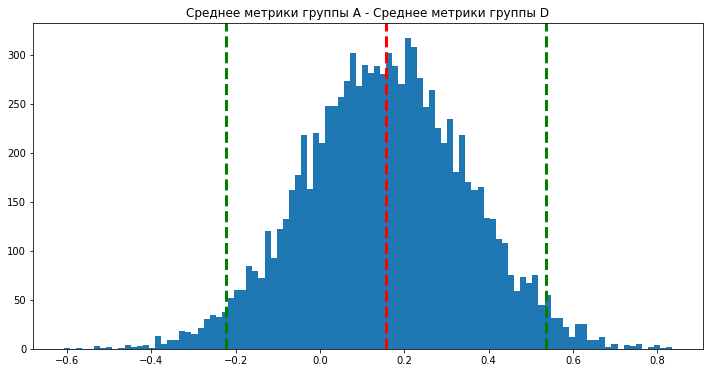

In [30]:
plt.figure(figsize=(12, 6))
plt.hist(bootstrap_diff, bins=100)
plt.title('Среднее метрики группы A - Среднее метрики группы D')
plt.axvline(x=np.mean(bootstrap_diff), linewidth=3, color='r',linestyle='--')
plt.axvline(x=np.percentile(bootstrap_diff, 2.5), linewidth=3, color='g',linestyle='--')
plt.axvline(x=np.percentile(bootstrap_diff, 97.5), linewidth=3, color='g',linestyle='--')
plt.show()

In [31]:
bs.bootstrap_ab(a.values, d.values, bs_stats.mean, bs_compare.difference)

0.15717566461132648    (-0.2194639130734869, 0.5309982514093149)

In [32]:
print(f"Доверительный интервал с уровнем доверия 0.95: {np.percentile(bootstrap_diff, 2.5)} - {np.percentile(bootstrap_diff, 97.5)}")

Доверительный интервал с уровнем доверия 0.95: -0.22300895310842594 - 0.5349286241110484


In [33]:
boot_pvalue(bootstrap_diff)

0.4204

p_value 0.4

Нет оснований отвергнуть нулевую гипотезу о равенстве распределений

**Задание 4**

Есть данные с большой дисперсии у метрики (диспресию метрики можно посчитать для каждой группы). Для их дальнейшего анализа дисперсию необходимо сократить. Как определить, что дисперсия действительно большая? Если она большая, как вы будете ее чистить? Ответ аргументировать и описать.  P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

Описание данных: 

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

*Вместе с ответом на задание приложить код*

In [34]:
data = pd.read_csv('test_1_1.csv', sep=';', index_col=0).metrics

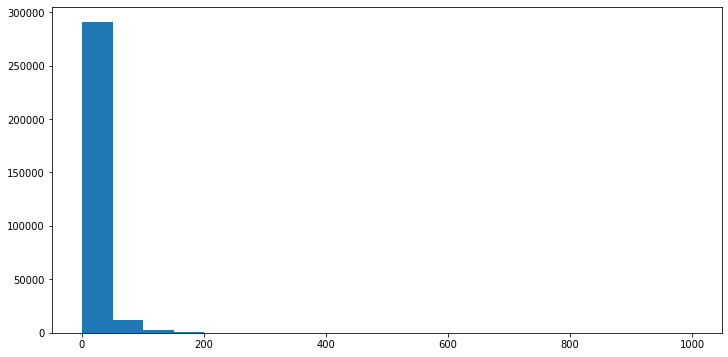

In [35]:
plt.figure(figsize=(12, 6))
plt.hist(data, bins=20)
plt.show()

Посчитаем коэффициент вариации

In [36]:
data.std() / data.mean()

2.2301166718750856

Данные неоднородны!

Применим преобразование Бокса-Кокса!

In [37]:
boxcox(data)[0].std() / boxcox(data)[0].mean()

0.9921945959199623

Кф вариации улучшился, но всё равно разброс очень большой. Данные неоднородны

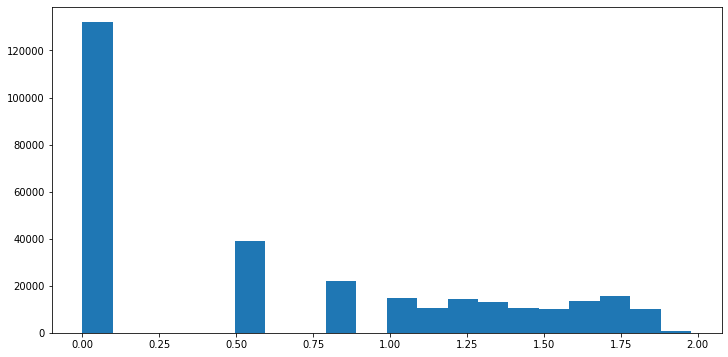

In [38]:
plt.figure(figsize=(12, 6))
plt.hist(boxcox(data)[0], bins=20)
plt.show()

Можно заметить, что в данных много выбросов, их можно почистить

Отбросим данные, которые больше перцентиля 99

In [39]:
data = data[data <= np.percentile(data, 99)]

In [40]:
data.std() / data.mean()

1.919830255705258

Можно попробовать опять преобразование бокса-кокса

In [41]:
boxcox(data)[0].std() / boxcox(data)[0].mean()

0.9958342203269728

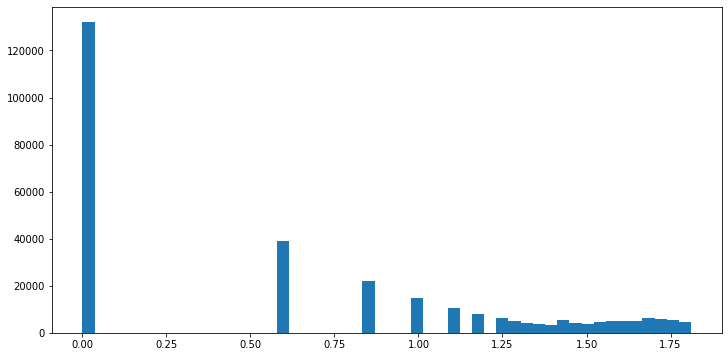

In [42]:
plt.figure(figsize=(12, 6))
plt.hist(boxcox(data)[0], bins=50)
plt.show()

Возьмём корень

In [43]:
np.sqrt(data).std() / np.sqrt(data).mean()

0.8558057979943985

Минимальный кф вариации у меня получился 0.85

Корень в этом случае лучше бокса кокса, потому что у нас дискретные положительные данные

**Задание 5**

Есть эксперимент с поисковыми подсказками. Вы хотим узнать, как изменился CTR в каждой группе эксперимента.

**Данные**

- id - уникальный идентификатор пользователя
- action -
- view - кол-во просмотров на одну сессию
- variant - вариант a/b теста, где 0 - это версия "A", 1 -  версия "B".

**Задача**

- сформировать метрику для оценки эксперимента
- подобрать критерий под особенности данных
- сделать вывод о значимости эффекта

**Данные** 

[Ссылка на данные](https://www.dropbox.com/s/fdki267uilkfq7l/task5.csv)

In [44]:
data = pd.read_csv('task5.csv', index_col=0)

Метрика CTR - action / view

In [45]:
data['ctr'] = data.action / data.view

In [46]:
data.head()

,variant,view,action,ctr
id,,,,
88258,A,10,2,0.200000
109938,A,3,1,0.333333
117644,A,7,5,0.714286
374080,A,9,9,1.000000
662082,A,1,1,1.000000


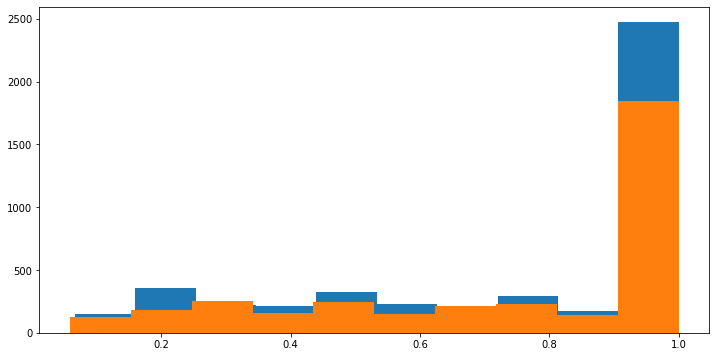

In [47]:
plt.figure(figsize=(12, 6))
plt.hist(data.query("variant == 'A'").ctr)
plt.hist(data.query("variant == 'B'").ctr)
plt.show()

In [48]:
len(data.query("variant == 'A'")), len(data.query("variant == 'B'"))

(4646, 3545)

Применим КС тест на проверку гипотезы о том, что группы принадлежат одному распределению

Тк размеры групп разные, для КС теста будем рандомно брать len(B) объектов группы А

Гипотеза H0 - группы из одного распределения. Гипотеза H1 - группы из разных распределений. Уровень значимости 0.05

In [49]:
p_values = []
for _ in range(1000):
    p_values.append(ks_2samp(np.random.choice(data.query("variant == 'A'").ctr, size=3545, replace=False),
             data.query("variant == 'B'").ctr).pvalue)

In [50]:
np.mean(p_values)

0.8420995866799605

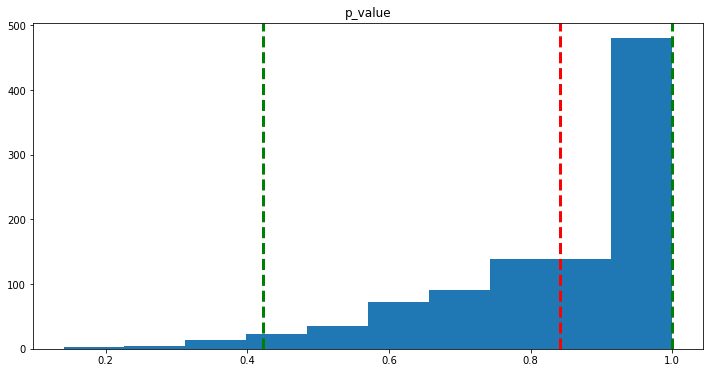

In [51]:
plt.figure(figsize=(12, 6))
plt.hist(p_values, bins=10)
plt.title('p_value')
plt.axvline(x=np.mean(p_values), linewidth=3, color='r',linestyle='--')
plt.axvline(x=np.percentile(p_values, 2.5), linewidth=3, color='g',linestyle='--')
plt.axvline(x=np.percentile(p_values, 97.5), linewidth=3, color='g',linestyle='--')
plt.show()

In [52]:
print(f"Доверительный интервал с уровнем доверия 0.95: {np.percentile(p_values, 2.5)} - {np.percentile(p_values, 97.5)}")

Доверительный интервал с уровнем доверия 0.95: 0.4226522237952153 - 0.9999522226572729


Нет оснований отвергнуть нулевую гипотезу о том, что CTR групп A и B принадлежат одному распределению

2 способ: непараметрический бутстрап

In [53]:
bootstrap_diff = []
for n in range(10000):
    sample_a = np.random.choice(data.query("variant == 'A'").ctr, size=len(data.query("variant == 'A'").ctr))
    sample_b = np.random.choice(data.query("variant == 'B'").ctr, size=len(data.query("variant == 'B'").ctr))
    diff = sample_a.mean() - sample_b.mean()
    bootstrap_diff.append(diff)

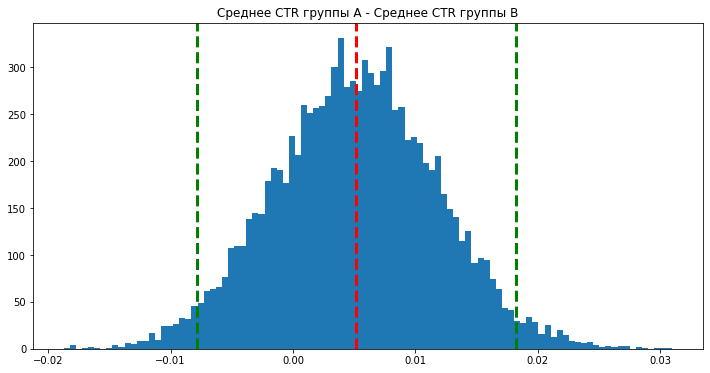

In [54]:
plt.figure(figsize=(12, 6))
plt.hist(bootstrap_diff, bins=100)
plt.title('Среднее CTR группы A - Среднее CTR группы B')
plt.axvline(x=np.mean(bootstrap_diff), linewidth=3, color='r',linestyle='--')
plt.axvline(x=np.percentile(bootstrap_diff, 2.5), linewidth=3, color='g',linestyle='--')
plt.axvline(x=np.percentile(bootstrap_diff, 97.5), linewidth=3, color='g',linestyle='--')
plt.show()

In [55]:
print(f"Доверительный интервал с уровнем доверия 0.95: {np.percentile(bootstrap_diff, 2.5)} - {np.percentile(bootstrap_diff, 97.5)}")

Доверительный интервал с уровнем доверия 0.95: -0.007842582212122065 - 0.01823753800223799


In [56]:
boot_pvalue(bootstrap_diff)

0.4428

Нет оснований отвергнуть нулевую гипотезу о том, что CTR групп A и B принадлежат одному распределению

Значит, разница статистически не значима, ctr в группах A и B не отличаются

In [57]:
bs.bootstrap_ab(data.query("variant == 'A'").ctr.values, 
                data.query("variant == 'B'").ctr.values, bs_stats.mean, bs_compare.difference)

0.0050862549859075346    (-0.008141466474186721, 0.017998594441980757)